In [9]:
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random

import keras.backend as K
from keras.models import load_model

In [10]:
def load_photos(directory):
    images = []
    labels_speed = []
    labels_dir = []
    dir_list = listdir(directory)
    random.shuffle(dir_list)
    for name in dir_list:
        filename = directory + '/' + name
        # load an image from file
        image = load_img(filename, target_size=(96, 160))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # get image id + labels
        value_dir = float(name.split('_')[1])
        value_speed = float(name.split('_')[0])
        labels_dir.append(value_dir)
        labels_speed.append(value_speed)
        images.append(image)
    return images, labels_speed, labels_dir

In [11]:
model_name="93_model_bigrace_original_5.h5"
model = load_model(model_name)

In [12]:
dataset = "BigOne_Race_5"

directory = dataset+'/Val'
images_val, labels_speed_val, labels_dir_val = load_photos(directory)
nb_images_val = len(images_val)
print('Loaded Images and labels for validation: %d' % nb_images_val)

images_val = np.array(images_val)
images_val /= 255.0

Loaded Images and labels for validation: 1645


In [13]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma

def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[2]
    imshape = imgs.shape[:2]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[:, :, i]
    
    return mosaic

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around plt.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    plt.colorbar(im, cax=cax)

def layer_to_visualize(layer, img):
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    C1 = convout1_f(np.expand_dims(img, axis=0))
    C1 = np.squeeze(C1)
    print("C1 shape : ", C1.shape)

    plt.figure(figsize=(15, 15))
    nice_imshow(plt.gca(), make_mosaic(C1, 4, 4), cmap=cm.binary)

0 <keras.engine.topology.InputLayer object at 0x7fcecccacd30>
1 <keras.layers.convolutional.Conv2D object at 0x7fcecccacda0>
2 <keras.layers.normalization.BatchNormalization object at 0x7fcecccacdd8>
3 <keras.layers.core.Activation object at 0x7fcecccacf28>
4 <keras.layers.convolutional.Conv2D object at 0x7fceccc9f208>
5 <keras.layers.normalization.BatchNormalization object at 0x7fceccc9f320>
6 <keras.layers.core.Activation object at 0x7fceccc9f470>
7 <keras.layers.core.Dropout object at 0x7fceccc9f4a8>
8 <keras.layers.convolutional.Conv2D object at 0x7fceccc9f4e0>
9 <keras.layers.normalization.BatchNormalization object at 0x7fcecccacfd0>
10 <keras.layers.core.Activation object at 0x7fcece2dca90>
11 <keras.layers.core.Flatten object at 0x7fcece2dc278>
12 <keras.layers.core.Dropout object at 0x7fcece2dccc0>
13 <keras.layers.core.Dense object at 0x7fcece2dcc18>
14 <keras.layers.normalization.BatchNormalization object at 0x7fcece2dc3c8>
15 <keras.layers.core.Activation object at 0x7fcece3

0 <keras.engine.topology.InputLayer object at 0x7fcecccacd30>
C1 shape :  (96, 160, 3)
1 <keras.layers.convolutional.Conv2D object at 0x7fcecccacda0>
C1 shape :  (46, 78, 2)
4 <keras.layers.convolutional.Conv2D object at 0x7fceccc9f208>
C1 shape :  (21, 37, 4)
8 <keras.layers.convolutional.Conv2D object at 0x7fceccc9f4e0>
C1 shape :  (9, 17, 8)


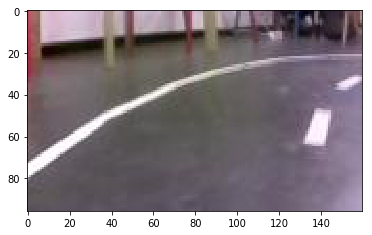

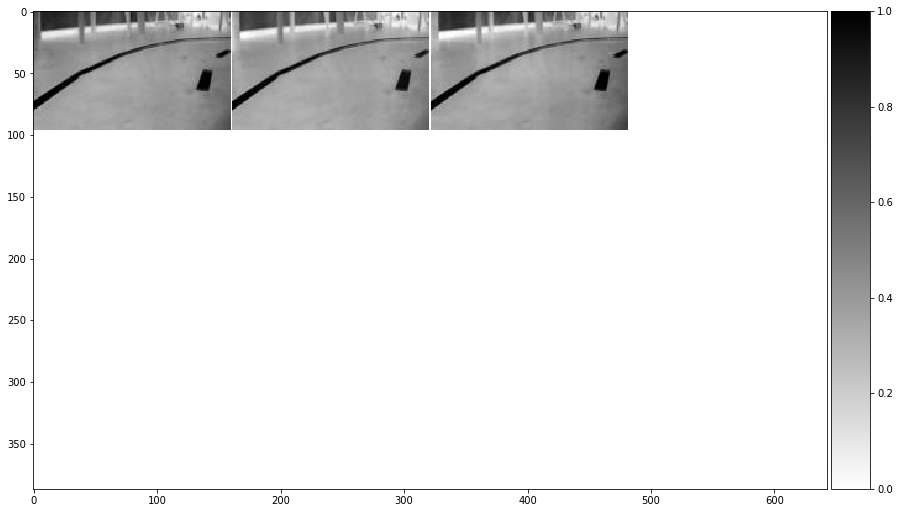

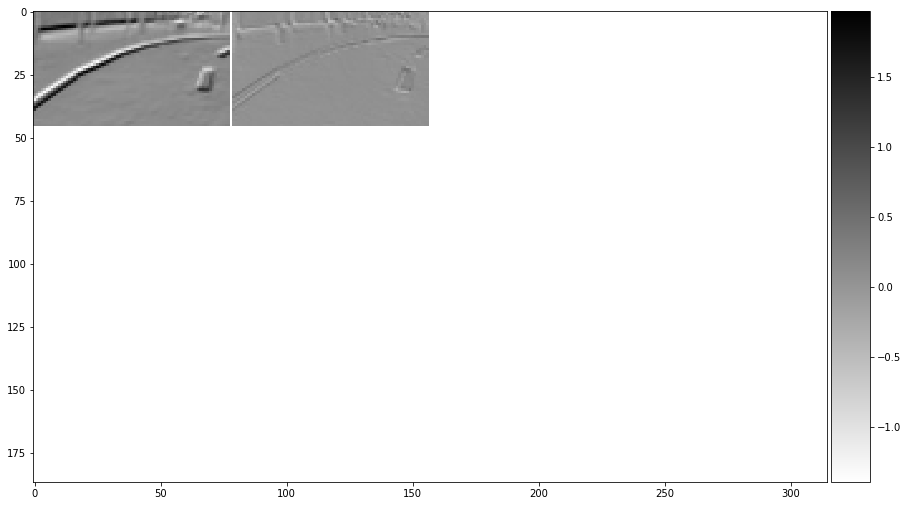

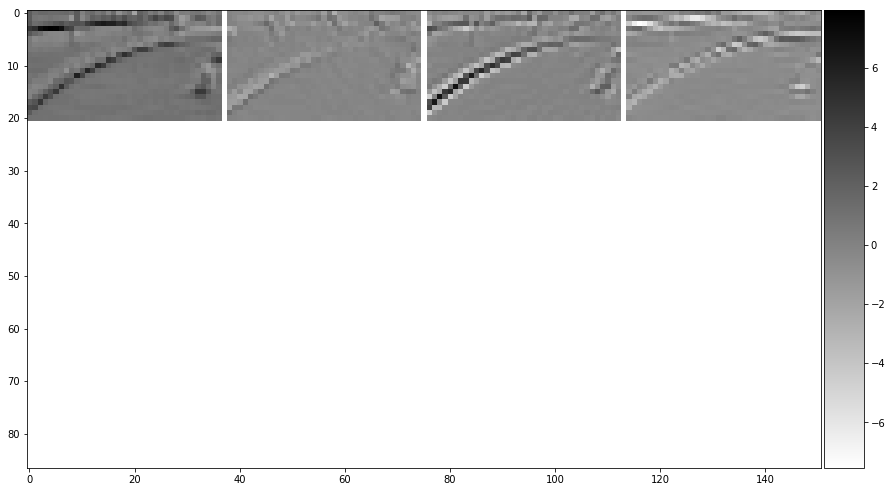

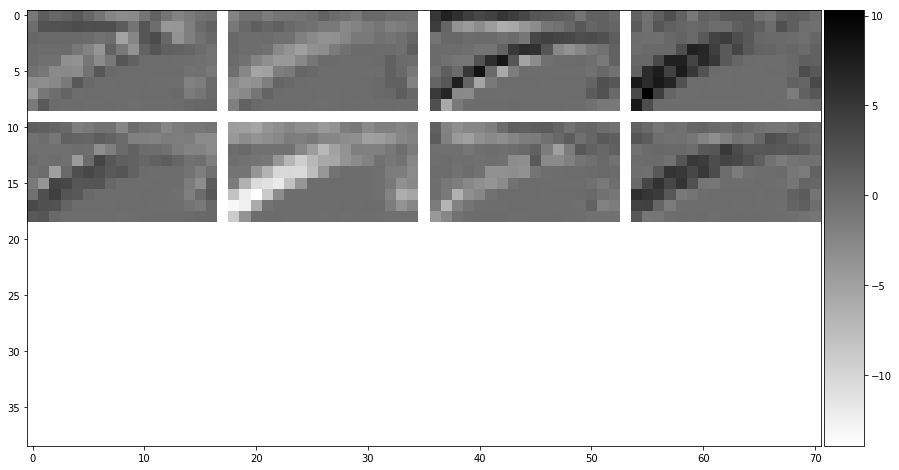

In [28]:
# Specify the image idx and the layer you want to visualize
idx = 42
img_to_visualize = images_val[idx]

plt.imshow(np.squeeze(img_to_visualize), cmap='gray')

for idx,layer in enumerate(model.layers):
    if 'conv2d' in layer.get_config()['name'] or idx == 0:
        print(str(idx), layer)
        layer_to_visualize(layer, img_to_visualize)